# Importing Libraries

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import numpy as np, pandas as pd

# need latest version of matplotlib >=(3.4.1), after upgrading please restart runtime
!pip install --upgrade matplotlib

import re
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase
from wordcloud import WordCloud, STOPWORDS

from sklearn.metrics import roc_curve, auc, roc_auc_score

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Importing Data and Exploratory Data Analysis

**Loading data**


*   Dataset is available in the Kaggle competition page.
*   There are 3 files provided in the competition, viz. train, test, sample submission all in CSV format.
*   Train dataset contains large number of Wikipedia comments and its corresponding class labels encoded in binary format.
*   Levels of toxicity i.e. class labels are toxic, severe_toxic, obscene, threat, insult, identity_hate.





In [33]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')  
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')
test_y = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_labels.csv') 

**Data Analysis**

**1.  Shape of the dataset**

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train.shape

(159571, 8)

In [6]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
test.shape

(153164, 2)

The training data contains 159,571 observations with 8 columns. Out of 8 columns, 6 columns are class labels and 1 column is for comment and one more column is id to identify a row uniquely. And the test data contains 153,164 observations with 2 columns.

In [8]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [19]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

**2.  Check for duplicates and missing values**

Following checking shows there were not any missing or duplicate values in training dataset and test dataset.

In [10]:
train.isnull().values.any()
train.duplicated().values.any()

False

In [11]:
test.isnull().values.any()
test.duplicated().values.any()

False

**3. Counts of Toxic & Non-Toxic comments**

In [12]:
print(matplotlib.__version__)

3.5.1


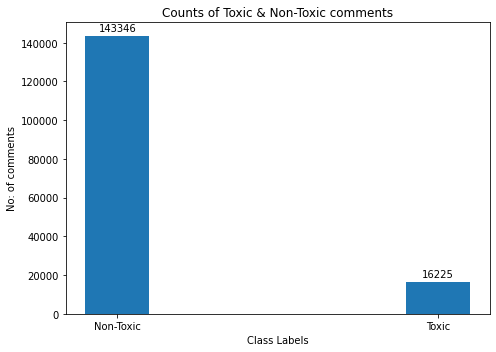

In [13]:
# plotting toxic & non-toxic comment counts
# If sum of all rows is equal to zero then a comment is clean.
categories=["Non-Toxic","Toxic"]
counts = [0, 0]

rowsums=train.iloc[:,2:].sum(axis=1)
all_zero =(rowsums==0)
# count of non-toxic
counts[0] = all_zero.sum()
# count of toxic
counts[1] = len(train) - counts[0]

# plt.bar(categories, counts)
fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(categories, counts, 0.2)
ax.set_ylabel('No: of comments')
ax.set_xlabel("Class Labels")
ax.set_title('Counts of Toxic & Non-Toxic comments')
ax.bar_label(rects1, padding=3)
fig.tight_layout()
plt.show()

*   There are 1,43,346 comments belongs to none of the target labels ie Non-Toxic. It is 89.832% of total data. There are 16,225 comments belongs to atleast one of the 6 target labels, i.e toxic comments.
*   From this plot we can understand that the data set is **highly imbalanced**.

In [14]:
newdf = train[(train['toxic'] == 0) & (train.iloc[:,3:].sum(axis=1) > 1 )]

In [15]:
newdf.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1867,050c330758a40c44,"""=Reliable sources===\nCheating:\n""""Barry Bond...",0,0,1,0,1,0
2537,06c8c299abebc705,"""\nLecture someone else, Sarah. You are talkin...",0,0,1,0,1,0
2678,0735c7334d85c6aa,Issues with Knox \n\nKnox run things like Gala...,0,0,1,0,1,0
2897,07d2ed1f32b003c6,I just learned how to suck up to people. You'r...,0,0,1,0,1,0
3233,08bb114239b4e0be,"""\n\nHonestly, I don't even remember making th...",0,0,1,0,1,0


**4. Lables Frequency**  
A comment may belongs to none or more targets labels. Lets count the no :of comments that belongs to multiple target labels. Further exploratory shows that label toxic has the most observations in the training dataset while threat has the least.

In [16]:
# Subsetting labels from the training data
labels = ['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']
train_labels = train[labels]
label_count = train_labels.sum()
print(label_count)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [17]:
train_labels.shape

(159571, 6)

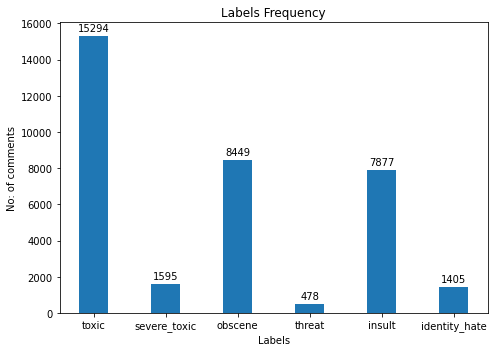

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(labels, label_count, 0.4)
ax.set_ylabel('No: of comments')
ax.set_xlabel("Labels")
ax.set_title('Labels Frequency')
ax.bar_label(rects1, padding=3)
fig.tight_layout()
plt.show()

**5. Correlation between Target Labels**

<AxesSubplot:>

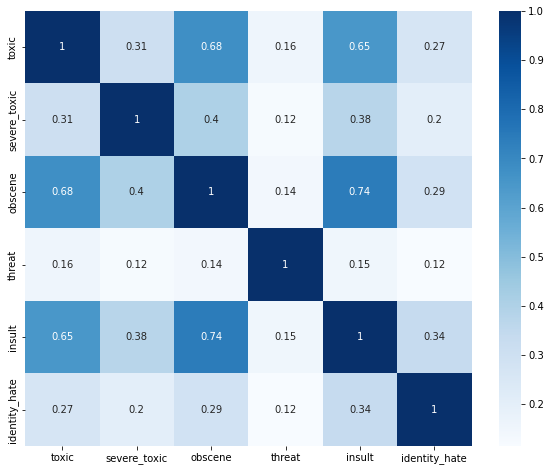

In [19]:
# Cross correlation matrix across labels
corr_df=train.drop(columns=["id","comment_text"])
correlation=corr_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation,
            xticklabels=corr_df.columns.values,
            yticklabels=corr_df.columns.values, annot=True, cmap="Blues")

The correlation matrix below provides more insight into these overlapping categories.  

1) From the correlation Map, we can understand that the toxic--> is much correlated with obscene,insult and severe_toxic.

2) Obscene is much more correlated with insult and toxic target classes. Threat doesn’t have much overlap.

**6. Word Cloud**  
In this section, let us plot the word cloud on the comment_text feature in order to bring the most common/occuring word under each target and each class.

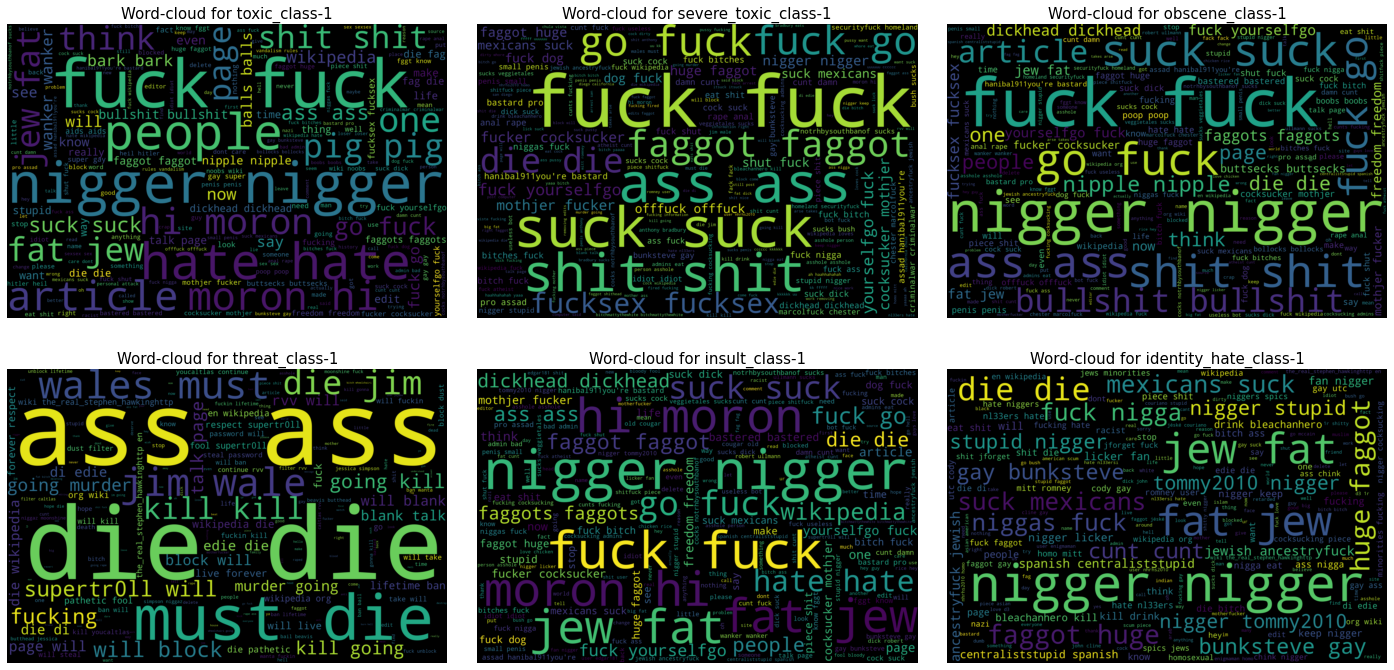

In [21]:
#doc: https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(20,10))
count=1
for col in train.columns[2:]:
    toxic_class_1 = train[train[col]==1]['comment_text'].str.lower().values
    wordcloud = WordCloud(width=3000, height=2000,
                          background_color ='black', margin=1,
                          stopwords = STOPWORDS,
                          ).generate(" ".join(toxic_class_1))

    plt.subplot(2,3,count)
    plt.axis("off")
    plt.title("Word-cloud for "+col+"_class-1",fontsize=15)
    plt.tight_layout(pad=3)
    plt.imshow(wordcloud,interpolation='bilinear')
    count=count+1
plt.show()

In [22]:
non_toxic_df = train[(train.iloc[:,2:].sum(axis=1) == 0 )]

In [23]:
non_toxic_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


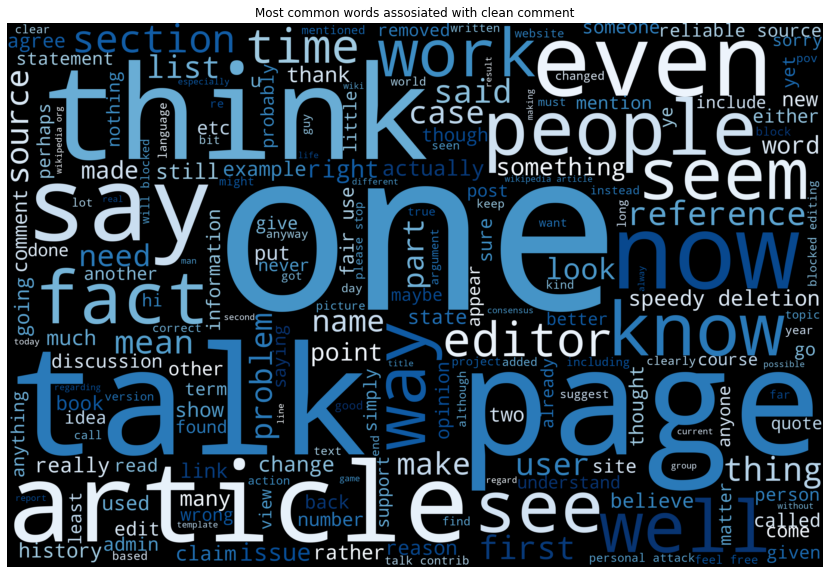

In [28]:
non_toxic_text = pd.Series(non_toxic_df.comment_text).str.lower().values
wordcloud = WordCloud(width=3000, height=2000,
                          background_color ='black', margin=1,
                          stopwords = STOPWORDS,
                          ).generate(" ".join(non_toxic_text))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title("Most common words assosiated with clean comment")
plt.show()

#Data Pre-processing

**1. Text Cleaning**


* Removing Numbers from the data
* Remove Punctuation
* Remove "\n"
* Remove digits
* Remove extra spaces if any
* Remove non-ASCII characters
* Remove urls
* Remove html tags
* Remove words with length less than 2
* Split combined words
* Convert data to lower-case





In [34]:
def clean_comment(text):
  '''a function for removing punctuation, removing \n, removing digits, lowercase'''
  import string

  # remove urls
  text = re.sub('http://\S+|https://\S+', '', text)

  # remove html from the text
  text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text)

  #'remove "\n"'
  text = re.sub(r"[\n\t\\\/]",' ',text)

  #'remove digits'
  text = re.sub(r'\d',' ',text)

  # Remove non-ASCII words
  text = re.sub("([^\x00-\x7F])+", '',text)


  # remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))

  # split combined words. For instance, converting whyAreYou to why Are You'
  text = re.sub(r'([a-z])([A-Z])',r'\1 \2',text)

  # remove words with length less than 2
  text = re.sub(r'\b\w{1,2}\b',"",text)

  # remove Whitespaces
  text = re.sub(r" {2,}",' ',text)

  # convert to lowercase
  text = text.lower()

  return text

train['comment_text'] = train['comment_text'].apply(clean_comment)
test['comment_text'] = test['comment_text'].apply(clean_comment)

train['comment_text'][1]


'daww matches this background colour seemingly stuck with thanks talk january utc'

In [27]:
train['comment_text'][101]

'check the following websites '

In [28]:
test['comment_text'][1]

' from the title fine imo'

**2. Remove Stopwords**   
Stop words means, which doesn't carry any importance in classification task. ie., words which are most occuring in the data-set and doesnt carry any importance in classifying either a positive/negative class. words like the, i , he, she, we, our, his, her, it, a , an, in, of, one, two, three, four, etc

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:

from nltk.corpus import stopwords

#sw=stopwords.words('english')
sw = nltk.corpus.stopwords.words('english')
#sw = set(stopwords.words('english'))
def remove_stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)
train['comment_text'] = train['comment_text'].apply(remove_stopwords)
test['comment_text'] = test['comment_text'].apply(remove_stopwords)

**3. Words Lemmatization**  
Lemmatization is the process of grouping different forms of words in to a single word. Lemmatization and stemming are similar. But Lemmatization brings the meaning to the context and morphological analysis.
   
   For Example

    Good--> Better--> Best all are based on the word "Good"

    Dogs--> Dog

    Apples--> Apple

In [37]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 
train['comment_text'] = train['comment_text'].apply(stemming)
test['comment_text'] = test['comment_text'].apply(stemming)

In [32]:
clean_data = train.drop(columns=['id'])
clean_data.sample(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
133668,look effect collis hard equat interest quantum...,0,0,0,0,0,0
116301,omg disput gay discuss omg bunch fuck nerd arg...,1,0,1,0,1,1
134063,transform game skydiv autobot cybertronian fig...,0,0,0,0,0,0
147352,pleas read wpbio write articl final put latim ...,0,0,0,0,0,0
118245,decis contest merg addit move page bell oppos ...,0,0,0,0,0,0


In [33]:
clean_data.to_csv('/content/drive/My Drive/Colab Notebooks/clean_train_labels.csv',
          header=True, index=False)

In [34]:
clean_test_data = test.drop(columns=['id'])
clean_test_data.sample(5)

,comment_text
110048,suppos technic speak photondriven process coul...
61154,agre bulk blofeld comment howev appreci sanger...
88894,present free meet tomorrow discuss sure remind...
23551,yeah blud fuck like diminish input ffwd gotta ...
1013,jazeera photo day ad photo day footag pleas ma...


In [35]:
clean_test_data.to_csv('/content/drive/My Drive/Colab Notebooks/clean_test_data.csv',
          header=True, index=False)

# Model Building

## Featurization
  
In this section, let us convert text features into vectors ie vectorization.
  
As we all know, machine learning and deep learning models work on numerical data irrespective of the use case. Therefore, to train a deep-learning model using the clean text data, the data must be converted into its equivalent machine-readable form. To achieve such a feat. we need to perform the following steps [3]:




1.   Tokenization — We need to break down the sentence into unique words. e.g. “I love cats and love dogs” will become [“I”, “love”, “cats”, “and”, “dogs”].
2.   Indexing — We put the words in a dictionary-like structure and give them an index each e.g. {1: “I”,2: “love”,3: “cats”,4: “and”,5: “dogs”}.
3.   Index Representation- We could represent the sequence of words in the comments in the form of an index, and feed this chain of index into our deep-learning model. For e.g. [1,2,3,4,2,5].  

Using the “Tokenizer” class from the “Keras” library, the above-mentioned steps can be easily performed. This class allows vectorizing a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf, etc [4]. The code snippet below demonstrates the conversion of text data into sequence vectors.




In [38]:
max_features=100000   # how many unique words to use (i.e num rows in embedding vector)
maxpadlen = 200  # max number of words in a comment to use       
embedding_dim_fasttext = 300  # how big is each word vector

**Tokenization**

In [39]:
processed_train_data = train['comment_text'].values
processed_test_data = train['comment_text'].values

In [40]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [41]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  149887


**Padding**

Comments found on online forums or social media platforms are variable in length, some are one-word replies while others are vastly elaborated thoughts. Variable-length sentences are converted into variable-length sequence vectors and we cannot pass vectors of inconsistent lengths to our deep-learning model. To circumvent this issue, we use Padding. With the help of padding, we can make the shorter sentences as long as the others by filling the shortfall by zeros, and on the other hand, we can trim the longer ones to the same length as the short ones [3]. I used the “pad_sequences” function from the “Keras” library and, I fixed the sentence length at 200 words and applied post padding (i.e. for shorter sentences, 0’s will be added at the end of the sequence vector). As soon as we are done with the padding of our sequence vectors, we can start creating our deep-learning models.

In [42]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [43]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  708   294   169     6   268    98   157   704   169     6   708     2
    64    45    32     2     4   623    83    31   666   321     3     2
   549   851    32  2462   636    82   169     6    32   294    27   536
   499    11     8   359   294   366   302   188    11    48     9    70
   268   146    48     2    13     5   392  4405    14    32 30087    13
   294    32 30087   160   282   498     2   163   124   704    80    92
   146   566  1671    80   282    26   704  1451   146  1736   217    31
   217   440   649  3454   217   175     6    92   561  1187    39   135
   146  1519   119   217   333   146    18  1210    47    57    14     9
    79   400   146   578    77   282   124     8   168    80   525   263
  2331   594    77     6   447  1690   121   268   442   302     3   169
     6     6    77     8    77    45     3    32   146    77   169     6
    15     3    32   146    77   439    45   146    77     6   294   282
    98   157   704    14    

In [20]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [21]:
X_t = X_t[indices]
labels = y[indices]

In [22]:
test_split = 0.2 
num_test_samples = int(test_split*X_t.shape[0])
x_train = X_t[: -num_test_samples]
y_train = labels[: -num_test_samples]
x_test = X_t[-num_test_samples: ]
y_test = labels[-num_test_samples: ]

In [21]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_test.sum(axis=0))

Number of entries in each category:
training:  [12236  1287  6708   375  6237  1112]
validation:  [3058  308 1741  103 1640  293]


## Importing fastText's pre-trained word embeddings

Use pre-trained word embeddings from fastText to harness the power of Transfer Learning. To do so, load the fastText word embeddings into the notebook, and then, create an embedding matrix by assigning the vocabulary with the pre-trained word embeddings.

Read the fastText word vectors into a dictionary from word -> vector.

In [23]:
embeddings_index_fasttext = {}
f = open('/content/drive/My Drive/Colab Notebooks/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

Use these vectors to create our embedding matrix, with random initialization for words that aren't in fastText.

In [24]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
print(" Completed!")

 Completed!


## Creating Model

###  Baseline Model: Uni-directional LSTM

Uni-directional LSTM was chosen as the baseline model.The tensor from
the embedding layer was fed into uni-directional lstm with the output dimension set at 60. The LSTM architecture allows information to flow a longer path across the unrolled network.Then we also add a max pooling for important feature extraction and some dropout to the LSTM to resolve the overfitting problem.
To prevent overfitting,
dropout layer was added to the model with probability of dropout at 0.1. Finally, a fully connected
layer with sigmoid activation was added to convert the output of the dropout layer to probabilities
of each label.


baseline model
Input Layer-> Embedding Layer -> LSTM ->Pooling -> Dropout-> Dense

#### Model Architecture

In [25]:
# input layer -> embedding layer
sequence_input = Input(shape=(maxpadlen,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

# -> LSTM  ->Pooling ->Dropout ->Dense
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)
uni_LSTM_model = Model(sequence_input, preds)
uni_LSTM_model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = [keras.metrics.AUC(multi_label=True)])
# 'accuracy'
uni_LSTM_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44966400  
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           86640     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 6)                 366       
                                                             

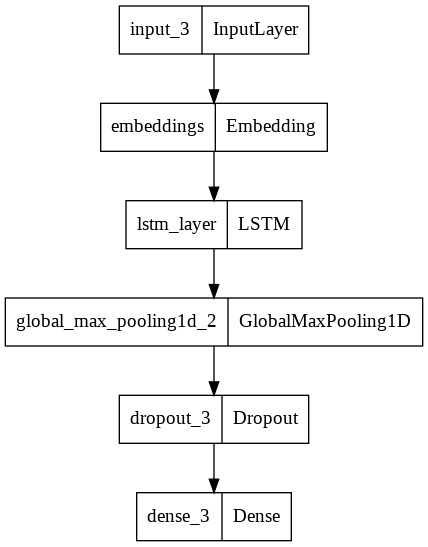

In [32]:
keras.utils.plot_model(uni_LSTM_model)

#### Model Training

In [26]:
print('Training progress:')
uni_LSTM_model_info = uni_LSTM_model.fit(x_train, y_train, epochs = 2, batch_size=32, validation_split=0.1)

Training progress:
Epoch 1/2
3591/3591 [==============================] - 498s 136ms/step - loss: 0.0685 - auc: 0.9271 - val_loss: 0.0521 - val_auc: 0.9617
Epoch 2/2
3591/3591 [==============================] - 467s 130ms/step - loss: 0.0524 - auc: 0.9624 - val_loss: 0.0502 - val_auc: 0.9634


#### Plot Metrics
  
From the baseline model, the performance measured based on ROC curves gave us the mean
ROC AUC of 0.96. The ROC AUC over the test set for the baseline model stood at 0.97.
As our dataset consisted of high number of non-toxic comments(true negatives), this might affect
ROC curves plot to be too optimistic as it is given by the true positive rate is TPR=TP/TP+FN and the false positive rate
i.e FP/FP+TN; but this metric is used to compare the results in the kaggle competition. Precison
and Recall performance was also observed to see the performance of the models which indicates
that labels with higher training examples exhibits a better PR performance curve.

We can see in the figures below , the ROC AUC curves are very close to the upper
left corner indicating a near perfect classification. The PR curve points out that the classes with
few training examples(threat,severe_toxic,identity_hate) have a weaker performance than
those with higher number of training examples.

In [27]:
print(uni_LSTM_model_info.history)

{'loss': [0.06849821656942368, 0.05235631763935089], 'auc': [0.9270942211151123, 0.962421715259552], 'val_loss': [0.05211280658841133, 0.05022265389561653], 'val_auc': [0.9617472290992737, 0.9633740782737732]}


**Plot loss**

In [35]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

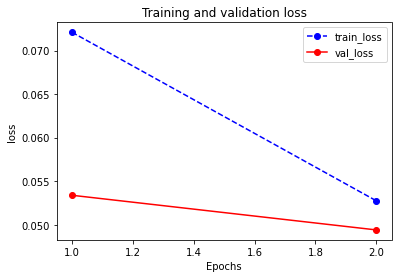

In [36]:
plot_metric(uni_LSTM_model_info, 'loss')

**plot ROC AUC**

In [28]:
y_train_pred = uni_LSTM_model.predict(x_train)

ROC AUC score: 0.9815461020994743


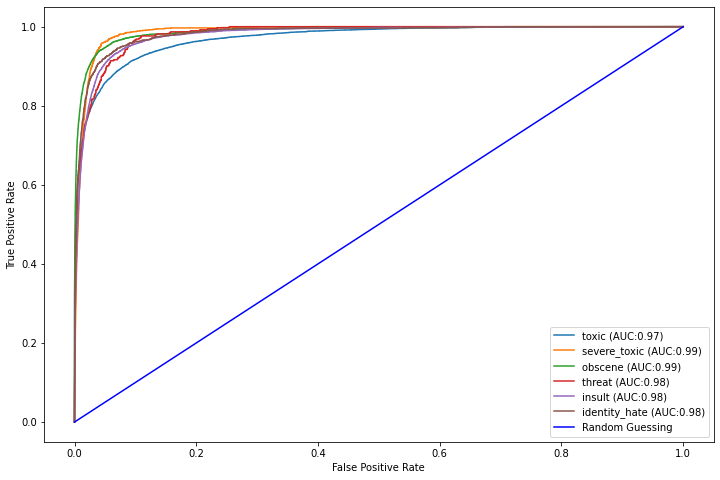

In [38]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
from sklearn.metrics import roc_curve, auc, roc_auc_score

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_train, y_train_pred, average="macro"):
    for (idx, c_label) in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_train[:,idx].astype(int), y_train_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_train, y_train_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_train, y_train_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [29]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, f1_score
f1 = f1_score(y_train, y_train_pred, average='macro')
print(f1)

ValueError: ignored

**Plot precision recall auc curve**

[0.09916146 0.09915417 0.09915498 ... 1.         1.         1.        ] [1.00000000e+00 9.99918454e-01 9.99918454e-01 ... 1.63092229e-04
 8.15461143e-05 0.00000000e+00]
[0.02548841 0.02546914 0.02546965 ... 1.         1.         1.        ] [1.00000000e+00 9.99224205e-01 9.99224205e-01 ... 1.55159038e-03
 7.75795190e-04 0.00000000e+00]
[0.05444375 0.05443613 0.05443657 ... 1.         1.         1.        ] [1.00000000e+00 9.99851962e-01 9.99851962e-01 ... 2.96076980e-04
 1.48038490e-04 0.00000000e+00]
[0.01170216 0.01167232 0.01167268 ... 1.         1.         1.        ] [1.         0.99738903 0.99738903 ... 0.00522193 0.00261097 0.        ]
[0.05208265 0.05207482 0.05207525 ... 1.         1.         1.        ] [1.00000000e+00 9.99841572e-01 9.99841572e-01 ... 3.16856781e-04
 1.58428390e-04 0.00000000e+00]
[0.01248881 0.0124779  0.01247803 ... 1.         1.         1.        ] [1.00000000e+00 9.99115044e-01 9.99115044e-01 ... 1.76991150e-03
 8.84955752e-04 0.00000000e+00]
precision r

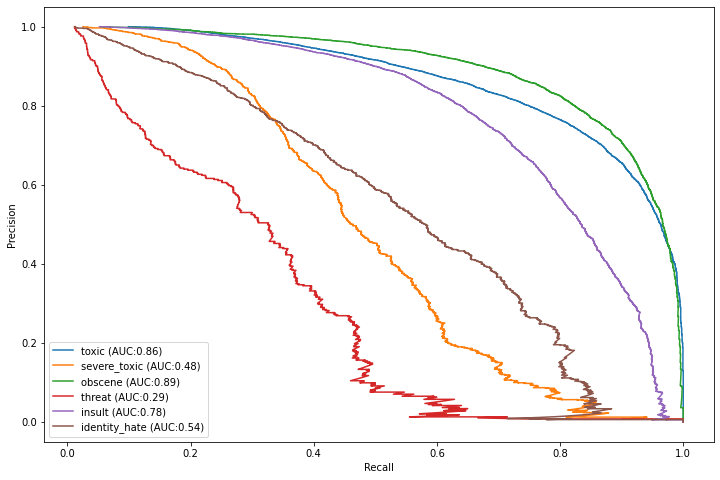

In [39]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, f1_score

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring precision recall auc score for multi-class
def multiclass_pr_auc_score(y_train, y_train_pred, average="macro"):

    for (idx, c_label) in enumerate(labels):
        precision, recall, thresholds = precision_recall_curve(y_train[:,idx].astype(int), y_train_pred[:,idx])
        print(precision, recall)
        c_ax.plot(precision, recall, label = '%s (AUC:%0.2f)'  % (c_label, auc(recall, precision)))
    return f1_score(y_train, y_train_pred, average='macro')

print('precision recall curve:', multiclass_pr_auc_score(y_train, y_train_pred))

c_ax.legend()
c_ax.set_xlabel('Recall')
c_ax.set_ylabel('Precision')
plt.show()

#### Model Evaluation
Evaluate on the test dataset

In [40]:
uni_LSTM_model.evaluate(x_test, y_test)

998/998 [==============================] - 18s 18ms/step - loss: 0.0487 - auc_2: 0.9701


[0.04868648201227188, 0.9700556397438049]

### Bidirectional LSTM

For a bidirectional LSTM architecture,everything remains same as unidirectional architecture as
described above but there will be one set of parameters for a forward unrolled LSTM and another
set for a backward unrolled LSTM that reads input token lists starting at the end rather than the
beginning.So, for each token position, there will be two output states at each time step.

#### Model Architecture

In [41]:
# input layer -> embedding layer
sequence_input = Input(shape=(maxpadlen,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

# -> LSTM  ->Pooling ->Dropout ->Dense
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer'))(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)
bi_LSTM_model = Model(sequence_input, preds)
bi_LSTM_model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = [keras.metrics.AUC(multi_label=True)])

bi_LSTM_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44966400  
                                                                 
 bidirectional (Bidirectiona  (None, 200, 120)         173280    
 l)                                                              
                                                                 
 global_max_pooling1d_3 (Glo  (None, 120)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 120)               0         
                                                                 
 dense_4 (Dense)             (None, 6)                 726 

#### Model Training

In [42]:
print('Training progress:')
bi_LSTM_model_info = bi_LSTM_model.fit(x_train, y_train, epochs = 2, batch_size=32, validation_split=0.1)

Training progress:
Epoch 1/2
3591/3591 [==============================] - 327s 90ms/step - loss: 0.0651 - auc_3: 0.9361 - val_loss: 0.0527 - val_auc_3: 0.9753
Epoch 2/2
3591/3591 [==============================] - 318s 89ms/step - loss: 0.0510 - auc_3: 0.9696 - val_loss: 0.0501 - val_auc_3: 0.9751


#### Plot Metrics

From the bidirectional LSTM model, the performance measured based on ROC curves was increased to be 0.97. The ROC AUC over the test set for the baseline model stood at 0.98.

Comparing to the uni-directional LSTM model, both the ROC AUC curve and the precision recall curve showed the performance of the bi-directional LSTM model was better.

In [43]:
print(bi_LSTM_model_info.history)

{'loss': [0.06514348834753036, 0.051031000912189484], 'auc_3': [0.9361116886138916, 0.9695515036582947], 'val_loss': [0.052746448665857315, 0.050099216401576996], 'val_auc_3': [0.975254237651825, 0.9750633239746094]}


**Plot loss**

In [44]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

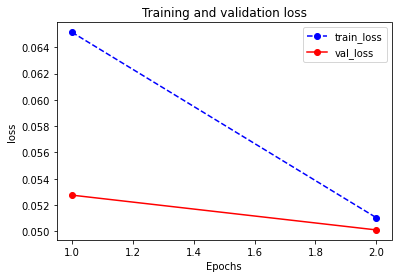

In [45]:
plot_metric(bi_LSTM_model_info, 'loss')

**plot ROC AUC**

In [47]:
y_train_pred = bi_LSTM_model.predict(x_train)

ROC AUC score: 0.9835929484972911


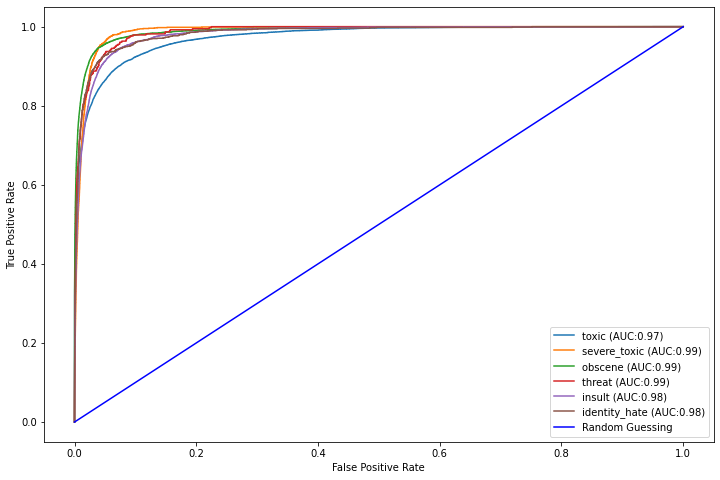

In [48]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
from sklearn.metrics import roc_curve, auc, roc_auc_score

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_train, y_train_pred, average="macro"):
    for (idx, c_label) in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_train[:,idx].astype(int), y_train_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_train, y_train_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_train, y_train_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

**Plot precision recall auc curve**

[0.09910456 0.09909728 0.09909808 ... 1.         1.         1.        ] [1.00000000e+00 9.99918454e-01 9.99918454e-01 ... 1.63092229e-04
 8.15461143e-05 0.00000000e+00]
[0.0336141  0.0335889  0.03358978 ... 1.         1.         1.        ] [1.00000000e+00 9.99224205e-01 9.99224205e-01 ... 1.55159038e-03
 7.75795190e-04 0.00000000e+00]
[0.06273333 0.06272463 0.06272521 ... 1.         1.         1.        ] [1.00000000e+00 9.99851962e-01 9.99851962e-01 ... 4.44115470e-04
 2.96076980e-04 0.00000000e+00]
[0.01321601 0.01318196 0.01318241 ... 1.         1.         1.        ] [1.         0.99738903 0.99738903 ... 0.00522193 0.00261097 0.        ]
[0.05194078 0.05193298 0.05193341 ... 1.         1.         1.        ] [1.00000000e+00 9.99841572e-01 9.99841572e-01 ... 3.16856781e-04
 1.58428390e-04 0.00000000e+00]
[0.01174612 0.01173584 0.01173597 ... 1.         1.         1.        ] [1.00000000e+00 9.99115044e-01 9.99115044e-01 ... 1.76991150e-03
 8.84955752e-04 0.00000000e+00]
precision r

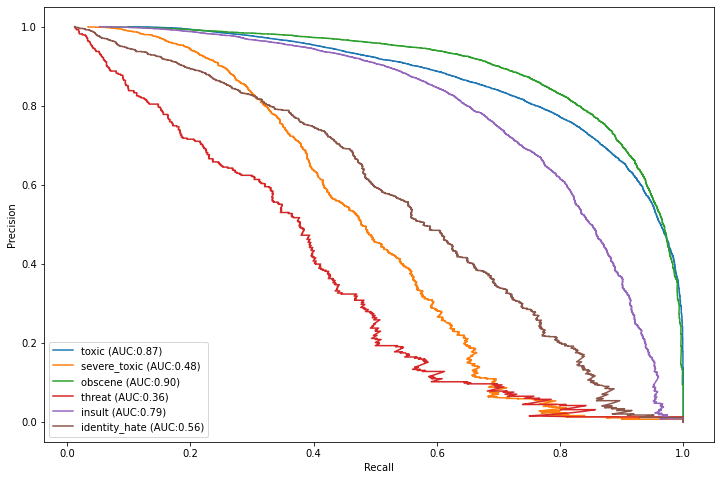

In [49]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, f1_score

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring precision recall auc score for multi-class
def multiclass_pr_auc_score(y_train, y_train_pred, average="macro"):

    for (idx, c_label) in enumerate(labels):
        precision, recall, thresholds = precision_recall_curve(y_train[:,idx].astype(int), y_train_pred[:,idx])
        print(precision, recall)
        c_ax.plot(precision, recall, label = '%s (AUC:%0.2f)'  % (c_label, auc(recall, precision)))

print('precision recall curve:', multiclass_pr_auc_score(y_train, y_train_pred))

c_ax.legend()
c_ax.set_xlabel('Recall')
c_ax.set_ylabel('Precision')
plt.show()

#### Model Evaluation
Evaluate on the test dataset

In [50]:
bi_LSTM_model.evaluate(x_test, y_test)

998/998 [==============================] - 34s 34ms/step - loss: 0.0483 - auc_3: 0.9768


[0.048338018357753754, 0.9767735004425049]

# Saving the Model

In [51]:
uni_LSTM_model.save(filepath="/content/drive/My Drive/Colab Notebooks/uni_LSTM_model")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/uni_LSTM_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/uni_LSTM_model/assets


In [52]:
bi_LSTM_model.save(filepath="/content/drive/My Drive/Colab Notebooks/bi_LSTM_model")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/bi_LSTM_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/bi_LSTM_model/assets


# Testing the Created Model

In [53]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = bi_LSTM_model.predict(new_string) #(Change to model_1 or model_2 depending on the preference of model type|| Model 1: LSTM, Model 2:LSTM-CNN)
    
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

In [54]:
toxicity_level('go jump off a bridge jerk')

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         87%
Severe Toxic:  3%
Obscene:       43%
Threat:        1%
Insult:        50%
Identity Hate: 1%



In [61]:
toxicity_level('kill you')

Toxicity levels for 'kill you':
Toxic:         63%
Severe Toxic:  6%
Obscene:       19%
Threat:        31%
Insult:        19%
Identity Hate: 3%



In [56]:
toxicity_level('have a nice day')

Toxicity levels for 'have a nice day':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [57]:
toxicity_level('fuck ofF!!')

Toxicity levels for 'fuck ofF!!':
Toxic:         99%
Severe Toxic:  23%
Obscene:       98%
Threat:        1%
Insult:        58%
Identity Hate: 2%



In [58]:
toxicity_level('Hello, How are you?')

Toxicity levels for 'Hello, How are you?':
Toxic:         2%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [60]:
toxicity_level('stupid girl!! Get away from me')

Toxicity levels for 'stupid girl!! Get away from me':
Toxic:         97%
Severe Toxic:  8%
Obscene:       61%
Threat:        1%
Insult:        75%
Identity Hate: 10%

